## Implement linear regression in tensorflow

- https://wookayin.github.io/tensorflow-talk-debugging/#35

In [1]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
    
import numpy as np
import matplotlib
from matplotlib  import pyplot as plt
import pprint
%matplotlib inline
np.__version__, tf.__version__

('1.13.0', '1.2.0')

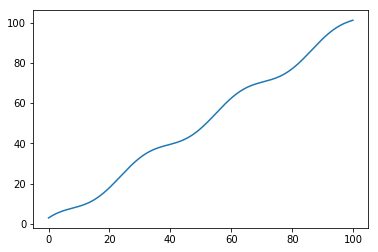

In [2]:
x = np.arange(100, step=0.1)
y = x + 3 * np.cos(x/5)  
plt.plot(x, y)

In [3]:
n_samples = 1000
batch_size = 10

# rewrite as column vector
x = np.reshape(x, (n_samples, 1))
y = np.reshape(y, (n_samples, 1)) 

#### Trying to load graph from python description in a file

In [25]:
import py_graph_def
from py_graph_def import linear_reg_graph
g = py_graph_def.linear_reg_graph.load_graph()
type(g.as_graph_def())

tensorflow.core.framework.graph_pb2.GraphDef

### Retraining in a new session using a past graph

Since Loading the graph description from a file was not successfull we can load it here.

Once the graph is build we can pass it to the session and keep with the training process

In [35]:
tf.reset_default_graph()
batch_size_ = 10
n_features_ = 1
linear_regression_graph = tf.Graph()
seed_val = 123

with linear_regression_graph.as_default():
    batch_size = batch_size_
    n_features = n_features_
    
    pl_x = tf.placeholder(tf.float32, shape=(batch_size, 1))
    pl_y = tf.placeholder(tf.float32, shape=(batch_size, 1))
    W = tf.get_variable("weights", (1,1), initializer=tf.random_normal_initializer(seed=seed_val))
    b = tf.get_variable("bias", (1,), initializer=tf.constant_initializer(0.))
    y_pred = tf.matmul(pl_x, W) + b    
    loss = tf.reduce_mean((pl_y - y_pred)**2/batch_size)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
    # Add allways the  tf.global_variables_initializer() and tf.Saver() in the graph
    init = tf.global_variables_initializer()   
    saver = tf.train.Saver()
    #saver.save(as_default, "./saved_tests/linear_regression_saver.ckpt")
    pprint.pprint(tf.global_variables())

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>]


In [36]:
tf.reset_default_graph()
n_epochs = 20
indices_batches = [ x for x in range(0, len(x) + 1, 10) ]

with tf.Session(graph=linear_regression_graph) as sess:
    saver.restore(sess,"./saved_tests/linear_regression_saver.ckpt") 
    print("\n\nShow me W and b")
    print("weights after training: ",sess.run([W]))
    print("bias after training: ",sess.run([b]), "\n")
    
    for epoch in range(n_epochs):
        mean_loss = []
        for b_beg, b_end in zip(indices_batches[0:-1], indices_batches[1:]):
            _, l = sess.run([optimizer, loss], feed_dict={pl_x: x[b_beg:b_end], 
                                                          pl_y: y[b_beg:b_end]})
            mean_loss.append(l)
        print("epoch: ", epoch, " loss: ", np.mean(mean_loss))


INFO:tensorflow:Restoring parameters from ./saved_tests/linear_regression_saver.ckpt


Show me W and b
weights after training:  [array([[ 1.01322317]], dtype=float32)]
bias after training:  [array([-0.06743076], dtype=float32)] 

epoch:  0  loss:  0.167117
epoch:  1  loss:  0.167117
epoch:  2  loss:  0.167117
epoch:  3  loss:  0.167117
epoch:  4  loss:  0.167118
epoch:  5  loss:  0.167118
epoch:  6  loss:  0.167118
epoch:  7  loss:  0.167119
epoch:  8  loss:  0.167119
epoch:  9  loss:  0.167119
epoch:  10  loss:  0.16712
epoch:  11  loss:  0.16712
epoch:  12  loss:  0.16712
epoch:  13  loss:  0.167121
epoch:  14  loss:  0.167121
epoch:  15  loss:  0.167121
epoch:  16  loss:  0.167122
epoch:  17  loss:  0.167122
epoch:  18  loss:  0.167123
epoch:  19  loss:  0.167123


## Can we do it without the python code?

In [33]:
tf.reset_default_graph()
n_epochs = 20
indices_batches = [ x for x in range(0, len(x) + 1, 10) ]

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph("./saved_tests/linear_regression_saver.meta")
    new_saver.restore(sess, './saved_tests/')

    print("\n\n\tShow me W and b")
    print("weights after trainin: ",sess.run([W]))
    print("")
    
    for epoch in range(n_epochs):
        mean_loss = []
        for b_beg, b_end in zip(indices_batches[0:-1], indices_batches[1:]):
            _, l = sess.run([optimizer, loss], feed_dict={pl_x: x[b_beg:b_end], 
                                                          pl_y: y[b_beg:b_end]})
            mean_loss.append(l)
        print("epoch: ", epoch, " loss: ", np.mean(mean_loss))
        

INFO:tensorflow:Restoring parameters from ./saved_tests/


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./saved_tests/
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]

Caused by op 'save/RestoreV2_1', defined at:
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-dd10a8ecabff>", line 6, in <module>
    new_saver = tf.train.import_meta_graph("./saved_tests/linear_regression_saver.meta")
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1686, in import_meta_graph
    **kwargs)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 504, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 311, in import_graph_def
    op_def=op_def)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/david/anaconda/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./saved_tests/
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]


In [ ]:
#with tf.gfile.FastGFile("./saved_tests/linear_regression.cpkt") as f:
#    graph_def = tf.GraphDef()
#    graph_def.ParseFromString(f.read())
#    _ = tf.import_graph_def(graph_def, name="")

## Linear regression as  learn.estimator

In [ ]:
def linear_regression(features, target):

    pl_x = tf.placeholder(tf.float32, shape=(batch_size, 1))
    pl_y = tf.placeholder(tf.float32, shape=(batch_size, 1))
    W = tf.get_variable("weights", (1,1), initializer=tf.random_normal_initializer(seed=seed_val))
    b = tf.get_variable("bias", (1,), initializer=tf.constant_initializer(0.))
    y_pred = tf.matmul(pl_x, W) + b    
    loss = tf.reduce_mean((pl_y - y_pred)**2/n_samples)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
    # Add allways the  tf.global_variables_initializer() and tf.Saver() in the graph
    init = tf.global_variables_initializer()   
    saver = tf.train.Saver()

